# Tutorial 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.linalg import svdvals
from scipy.sparse import spdiags

from functools import partial
from itertools import pairwise

from deconvolution import (
    BlurringOperator,
    MixtureDistribution,
    toeplitz_structure,
    variable_projection_total_variation)


### Latent Signal 

Suppose the latent signal is provided by the function
$$x_{true}(t_i) = \begin{cases}
0,\quad -N\leq t_i<-N/6 \\
1,\quad -N/6 \leq t_i < N/6 \\ 
0,\quad N/6 \leq t_i \leq N
\end{cases}$$
where $x_{true}(t_i)$ is the intensity of each pixel $t_i$. 

Define the domain to be equally spaced points in some interval

In [2]:
def equispaced_points(number_of_points):
    """Returns an equally spaced array centered about zero
    with `number_of_points + 1` points."""
    return np.arange(
        -number_of_points // 2,
        number_of_points // 2 + 1,
        dtype=float)


Suppose the `number_of_points` is given to be $N$. 

The $N+1$ *equispaced points* may be determined by the formula $t_i = t_{i-1} + 1$ where $t_1 = -\lceil N / 2 \rceil$. 

Why do we choose equally spaced points? 🤔

### Constructing the Domain

In [3]:
t = equispaced_points(number_of_points=128)  # returns 129 points total


Here we have a vector of 129 points where each point is equally spaced in an interval centered about the origin. 

### Constructing the latent signal

In [4]:
N = t.size
latent_signal = np.piecewise(
    t,
    [t < N/6, -N/6 <= t, N/6 <= t],
    [0, 1, 0])


We can construct this latent signal using the `numpy` function `piecewise`.

### The Latent Signal

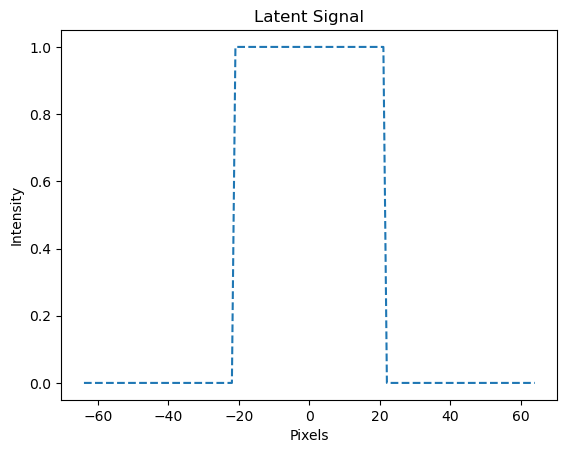

In [5]:
plt.plot(t, latent_signal, '--')
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.title('Latent Signal');


### Convolution 

$$ (f*g)(t) = \int_{-\infty}^{\infty}f(\tau)g(t-\tau)\tau'$$

The kernel is assumed to be a mixture distribution 

### Mixture Distribution

The mixture distribution $p$ is determined by weights and parameterized mixture components.

$$p(y)=\sum_{k=1}^nw_k p_k(\theta_k)$$

The distributions $p_k$ are the mixture components, $w_k$ denotes the mixture weights, and $\theta_k$
are the parameters for each component in the mixture. And $y=(w_1,\dots,w_n,\theta_1,\dots,\theta_n)$. 

In our case let each mixture component be a normal distribution. 

### Normal Distribution

In [6]:
def normal_distribution(domain, standard_deviation):
    t = domain
    sigma = standard_deviation
    gaussian = np.exp(-0.5 * (t / sigma)**2)
    normalization_constant = 1/sum(gaussian)
    return gaussian * normalization_constant


### Derivatives

The derivative with respect to the standard deviation 

In [7]:
def derivative_wrt_standard_deviation(domain, standard_deviation):
    t = domain
    sigma = standard_deviation

    return normal_distribution(t, sigma) * (t**2) / (sigma**3)


The derivative with repect to the *standard deviation* is provided by 

$$\frac{\partial f}{\partial \mu} = \frac{t_i^2}{\sigma^3} e^{-\frac{1}{2}(\frac{t_i}{\sigma})^2}$$

### Parameters

First lets define the weights and the parameters of the mixture. 

In [8]:
true_weights = np.array([0.5, 0.5])  # mixture weights
true_standard_deviations = np.array([10, 20])  # parameter


### Construct the mixture model

In [9]:
true_mixture_model = MixtureDistribution(
    domain=t,
    mixture_weights=true_weights,
    mixture_component_parameters=true_standard_deviations,
    mixture_components=[normal_distribution, normal_distribution],
    mixture_component_derivatives=[derivative_wrt_standard_deviation])


### The Mixture Model

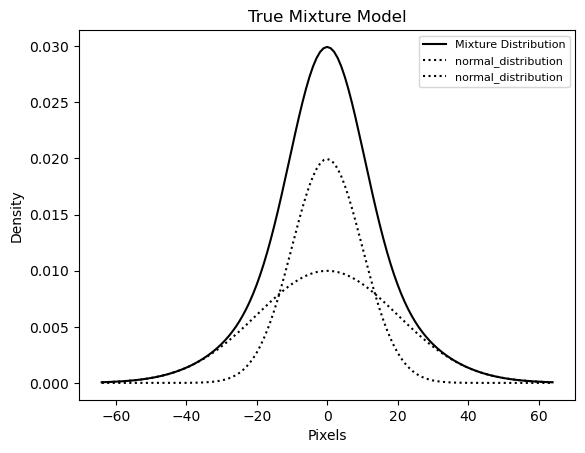

In [10]:
true_mixture_model.visualize_mixture('True Mixture Model')


### Construct the blurring operator

In [11]:
blur = BlurringOperator(true_mixture_model.array, toeplitz_structure)


#### Visualizing the Blurring Matrix

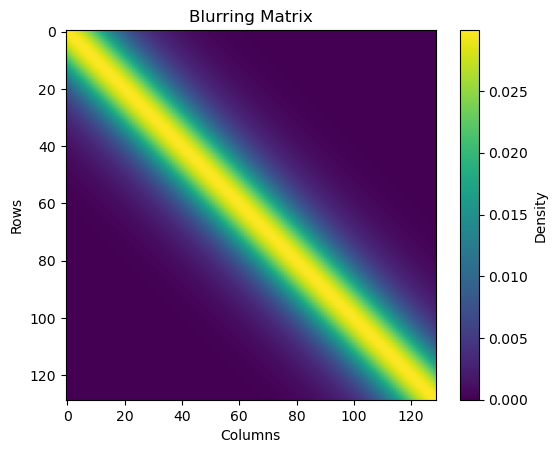

In [12]:
plt.imshow(blur.matrix)
plt.colorbar(label='Density')
plt.ylabel('Rows')
plt.xlabel('Columns')
plt.title('Blurring Matrix');


### Noise 

Lets say the data contains some percentage of gaussian noise

In [13]:
def guassian_noise(percentage, latent_signal):
    np.random.seed(1) # Control randomness 
    mu = 0 # Mean 
    std = latent_signal.std() # Standard deviation
    N = latent_signal.size # number of points 
    random_noise = np.random.normal(loc=0, scale=std, size=N)
    return  random_noise * percentage


Setting the percentage of random noise in the data.

In [14]:
percentage = 0.05


Creating the noise.

In [15]:
noise = guassian_noise(percentage, latent_signal)


### Lets Plot the Noise

In [16]:
def visualize(t, noise):
    fig = plt.figure()
    gs = fig.add_gridspec(1,2, width_ratios=(4, 1), left=0.1, right=0.9, 
                      bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
    ax1 = fig.add_subplot(gs[0,0])
    ax1.grid(True)
    ax1.set_ylabel('Noise')
    ax1.set_xlabel('Per Pixel') 

    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax2.tick_params(axis="y", labelleft=False)
    ax2.set_xlabel('Count')

    ax1.plot(t, noise)
    ax2.hist(noise, 20, density=True, orientation='horizontal')


### The Noise

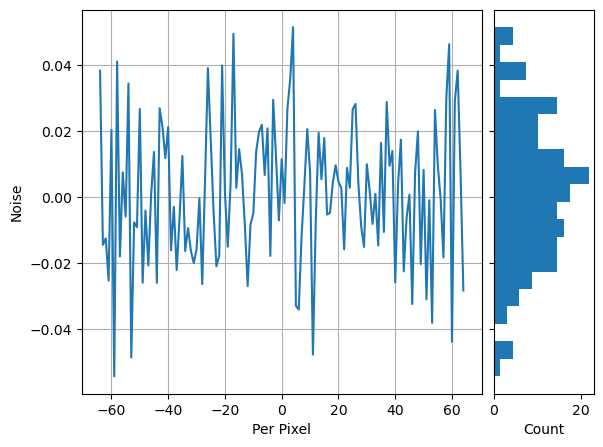

In [17]:
visualize(t, noise)

### The Data

In [18]:
data = blur @ latent_signal + noise

### Visualizing the Data

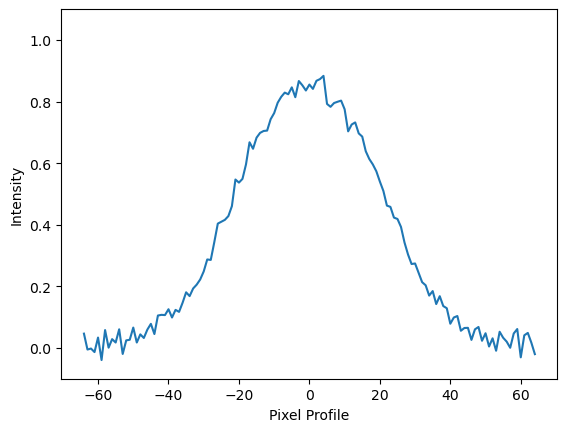

In [19]:
plt.plot(t, data)
plt.xlabel('Pixel Profile')
plt.ylabel('Intensity')
plt.ylim([-0.1, 1.1]);

## Deconvolution 

Aim is to solve the optimization problem 

$$\min_{x,y}\{\|K(y) x - d\|_2^2 + \lambda^2 \|L x\|^2_2 \}$$

where 

$K(y)\in\mathbb{R}^{m\times m}$: blurring matrix, 

$y\in\mathbb{R}^{k}$: parameters for kernel of convolution, 

$x\in\mathbb{R}^{m}$: signal, 

$d\in\mathbb{R}^m$: data containing convoluted latent signal plus additive noise, 

$\lambda>0$: regularization parameter, 

$L\in\mathbb{R}^{m\times m}$: regularization matrix.

### Initial Kernel Mixture

In [20]:
initial_weights = np.array([0.5, 0.5])
initial_standard_deviations = np.array([15, 30])

In [21]:
initial_mixture_model = MixtureDistribution(
    domain=t,
    mixture_weights=initial_weights,
    mixture_component_parameters=initial_standard_deviations,
    mixture_components=[normal_distribution, normal_distribution],
    mixture_component_derivatives=[
        derivative_wrt_standard_deviation])
    

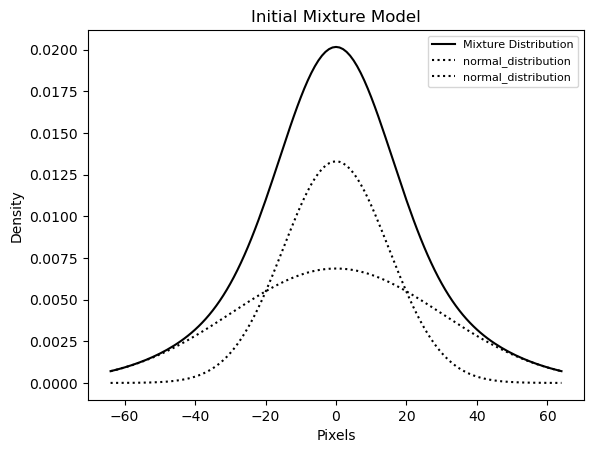

In [22]:
initial_mixture_model.visualize_mixture('Initial Mixture Model')

### Regularization Matrix

In [23]:
def total_variation(x):
    BETA = 1e-16
    ones = np.ones_like(x)
    D = spdiags([-ones, ones], diags=[0, 1]) # forward difference
    return np.diag(1/(((D*x)**2 + BETA**2)**(1/4))) @ D


### Jacobian

In [24]:
def rjf_jacobian(signal, partial_derivatives, structure):
    result = []
    for derivative in partial_derivatives:
        matrix = structure(derivative, derivative.size // 2)
        result.append(matrix @ signal)
    return np.array(result).T


### Variable Projection Method

In [25]:
mixture_model, result = variable_projection_total_variation(
    data,
    initial_signal=latent_signal,
    initial_mixture_model=initial_mixture_model,
    blur_structure=partial(toeplitz_structure),
    jacobian=rjf_jacobian,
    regularization_parameter=0.1,
    regularization_matrix=total_variation,
    max_iterations=100)


8.691482329604305e-13


### The Mixture Model

In [26]:
initial_mixture_model = MixtureDistribution(
    domain=t,
    mixture_weights=initial_weights,
    mixture_component_parameters=initial_standard_deviations,
    mixture_components=[normal_distribution, normal_distribution],
    mixture_component_derivatives=[
        derivative_wrt_standard_deviation])

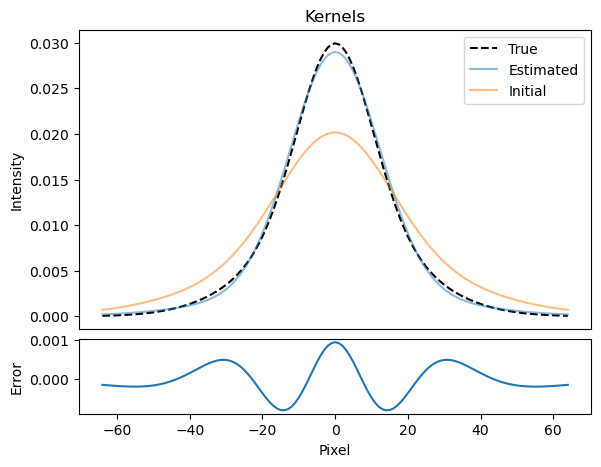

In [27]:
error = true_mixture_model.array - mixture_model.array

fig = plt.figure()
gs = fig.add_gridspec(2,1, height_ratios=(4, 1), left=0.1, right=0.9, 
                      bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(gs[0,0])
ax1.set_ylabel('Intensity')
ax1.tick_params(axis="x", bottom=False)

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.set_ylabel('Error')
ax2.set_xlabel('Pixel')

ax1.plot(t, true_mixture_model.array, 'k--', label='True')
ax1.plot(t, mixture_model.array, alpha=0.5, label='Estimated')
ax1.plot(t, initial_mixture_model.array, alpha=0.5, label='Initial')
ax2.plot(t, error)

ax1.set_title('Kernels')
ax1.legend();

0.007022880755817695

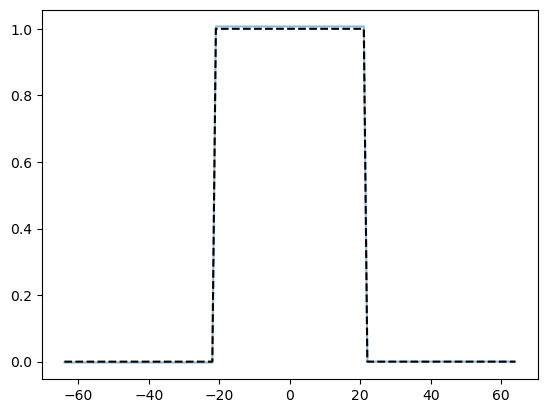

In [35]:
plt.plot(t, result, alpha=0.5)
plt.plot(t,latent_signal, 'k--');
np.linalg.norm(latent_signal - result, np.inf)

In [ ]:
# !jupyter nbconvert example.ipynb --to slides --post serve